## Implementing the model with fishing
We add fishing in the model, targetting the predator, with an off-target effect on the prey.
We note :
- $p_F $ the fishing intensity of the preys
- $p_N$ the fishing intensity of the predator


Assuming $p_F < p_N $


\begin{equation*}
\begin{cases}
\frac{dF_1}{dt} = \delta_1 (K_1 - F_1(t)) - F_1(t)N(t)uA_1(u) - p_F F_1(t)  & \text{Density of prey in env. 1} \\
\frac{dF_2}{dt} = \delta_2 (K_2 - F_2(t)) - F_2(t)N(t)(1-u)A_2(u) - p_F F_2(t) & \text{Density of prey in env. 2} \\ 
\frac{dN}{dt}  =  (\beta(u) - \mu) N(t) - p_N N(t) & \text{Density of fish}
\end{cases}
\end{equation*}

\begin{equation}
\beta(u) = 
\underbrace{F_1(t)}_{\text{(prey density)}}
\underbrace{A_1(u)}_{\text{(search rate)}}
\underbrace{u}_{\text{(time spent)}} + 
\underbrace{F_2(t)}_{\text{(prey density)}}
\underbrace{A_2(u)}_{\text{(search rate)}}
\underbrace{(1-u)}_{\text{(time spent)}}
\end{equation}

## Hypothesis of the adaptive dynamics
- The resident is at equilibrium ($N_r = N_r^*$)
- The mutant population is small ($N_m << N_r$)
On top of these fundamental hypothesis, we assume here that the dynamics of the prey is faster than the predator's (Quasi-Steady-State, QSS), yielding:

\begin{align*}
\frac{dF_1}{dt} = \frac{dF_2}{dt} =& 0 \\ 
\Leftrightarrow& \begin{cases}
F_1^*(N_r, N_m) = \frac{\delta_1 K_1}{\delta_1 + N_r(t)rA_1(r) + N_m(t)mA_1(m) + p_F} & = \frac{\delta_1 K_1}{\delta_1 + N_r^*rA_1(r) + p_F}\\
F_2^*(N_r, N_m) = \frac{\delta_2 K_2}{\delta_2 + N_r(t)(1-r)A_2(r) + N_m(t)(1-m)A_2(m) + p_F} & = \frac{\delta_2 K_2}{\delta_2 + N_r^*(1-r)A_2(r) + p_F}\\
\end{cases}
\end{align*}


The system becomes:

\begin{align}
\begin{cases}
\frac{dN_r}{dt} &= [\beta(r, N_r(t), N_m(t)) - \mu - p_N] N_r(t)- p_N N_r(t)\\
\frac{dN_m}{dt} &= [\beta(m, N_r(t), N_m(t)) - \mu - p_N] N_m(t)\\
\end{cases}
\end{align}

Finding $N_r^*$ is not trivial, we'll do it numerically. Nevertheless we
can have a ballpark estimation by considering that
$\delta_1<< A_1(r)N^*$, $\delta_2<< A_2(r)N^*$, and $p_F<< A_1(r)N^*$ and $A_2(r)N^*$:

\begin{align*}
\beta(r, N_r(t), N_m(t)) - \mu - p_N&= 0\\
\frac{\delta_1 K_1 A_1(r) r}{A_1(r)rN^*+\delta_1+p_F} + \frac{\delta_2 K_2 A_2(r) r}{A_2(r)rN^*+\delta_2+p_F} - \mu - p_N &= 0\\
\frac{\delta_1 K_1 A_1(r) r}{A_1(r)rN^*} + \frac{\delta_2 K_2 A_2(r) r}{A_2(r)rN^*}  &\approx \mu + p_N\\
N^* &\approx \frac{\delta_1 K_1 + \delta_2 K_2}{\mu + p_N}\\
\end{align*}

Our goal is to compute the invasion growth rate of a mutant (with trait
$m$) in an environment set by a resident (with trait value $r$). We
denote this quantity $s_r(m)$.

### Invasion fitness of the mutant

The invasion fitness $s_r(m)$ is given by:

\begin{align*}
s_r(m) =& \beta(m, N^*, 0) - \mu - p_N \\
=& F_1(N^*, 0)mA_1(m) + F_2(N^*, 0)(1-m)A_2(1-m)\\
\end{align*}

Numerical Pairwise invasibility plot
=============================

We want to plot the subset of $[0,1]^2$ where:

\begin{equation}
s_r(m) > 0 \;\; \text{for} \;\; m,r \in [0,1]^2
\end{equation}

You will need the following functions: 
[`scipy.optimize.fsolve`](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.optimize.fsolve.html#scipy-optimize-fsolve),  Use the doc to
check what they are doing.


import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
from functools import partial

In [1]:
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
from functools import partial

In [33]:
p_common = { "b2":0, 'd1':1,'d2':1,'K1':1,'K2':1,'mu':0.1,}  # Values common for the three sets
p_neutral = {"a1": 1, "b1": 0, "a2":1, **p_common}           # Neutral set
p_strong1 = {"a1": 1, "b1": 1, "a2":2, 'pN':0, 'pF':0, **p_common}            # Strong efficiency in environment 2
p_strong2 = {"a1": 1, "b1": 1, "a2":2, 'pN':0.6, 'pF':0.6, **p_common}            # Strong efficiency in environment 2
p_weak = {"a1": 2, "b1": -1, "a2":1, **p_common}             # Strong efficiency in environment 1

In [2]:
def A(u, a, b):
    """Attack rate. Volume of prey cleared per unit of time.
    Phenomenlogical model assuming a simple linear relationship between the time spent u
    and the attack rate."""
    return(a + b * u)

def F1_QSS(r, d1, K1, a1, b1, Nr, pF, **kwargs):
    """Quasi-Steady state approximation of the density of prey in env 1."""
    return( (d1*K1)/(A(r, a1, b1)*r*Nr + d1 + pF))
           
def F2_QSS(r, d2, K2, a2, b2, Nr,  pF, **kwargs):
    """Quasi-Steady state approximation of the density of prey in env 1."""
    return( (d2*K2)/(A(r, a2, b2)*(1-r)*Nr + d2 + pF))
                 
def beta(u, F1, F2, a1, b1, a2, b2):
    """Birth rate of a predator with trait u"""
    return (  F1 * A(u, a1, b1) * u 
            + F2 * A(u, a2, b2) * (1-u)) 

def n_star_solve(r, a1, a2, b1, b2, K1, K2, d1, d2, mu, pF, pN, **kwargs):
    """Population size of the resident at equilibrium.
    
    The equilibrium of the resident is found by finding 
    its population size N* for which its growth rate is null. 
    """
    
    def ToSolve(Nr):
        F1_star = F1_QSS(r, d1, K1, a1, b1, Nr, pF)
        F2_star = F2_QSS(r, d2, K2, a2, b2, Nr, pF)
        growth_rate =  beta(r, F1_star, F2_star, a1, b1, a2, b2) - mu - pN
        return(growth_rate)
    # Rough estimate used to initialise the optimisation algorithm.
    estimate = (d1*K1+d2*K2)/mu
    
    return scipy.optimize.fsolve(ToSolve,x0=estimate)

In [3]:
def invasion_fitness(r,m, a1, b1, a2, b2, mu, K1, K2, d1, d2, pN, pF, **kwargs):
    n_star = n_star_solve(r, a1, a2, b1, b2, K1, K2, d1, d2, mu, pF, pN)
    F1_star = F1_QSS(r, d1, K1, a1, b1, n_star, pF)
    F2_star = F2_QSS(r, d2, K2, a2, b2, n_star, pF)
    mutant_growth_rate =  beta(m, F1_star, F2_star, a1, b1, a2, b2) - mu - pN
    return(mutant_growth_rate)

def PIP_matrix(r_vec, m_vec, a1, b1, a2, b2, mu, K1, K2, d1, d2, pN, pF, **kwargs):
    dim1 = len(r_vec)
    dim2 = len(m_vec)
    S = np.zeros((dim1, dim2))
    for i in range (dim1):
        for j in range(dim2):
            r = r_vec[i]
            m = m_vec[j]
            s = invasion_fitness(r,m, a1, b1, a2, b2, mu, K1, K2, d1, d2, pN, pF)
            S[j,i] = s
    return(S)

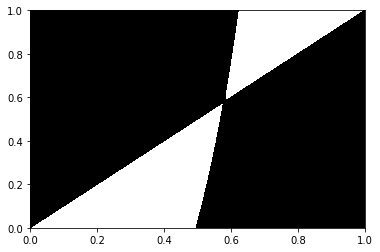

In [17]:
r_vec= m_vec = np.linspace(0,1,100)
S = PIP_matrix(r_vec, m_vec, **p_strong1)
R, M = np.meshgrid(r_vec, m_vec)
plt.contourf(R, M, S, levels=[np.min(S), 0, np.max(S)], colors=['w', 'k'])
plt.show()

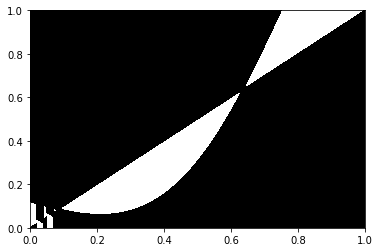

In [34]:
r_vec= m_vec = np.linspace(0,1,100)
S = PIP_matrix(r_vec, m_vec, **p_strong2)
R, M = np.meshgrid(r_vec, m_vec)
plt.contourf(R, M, S, levels=[np.min(S), 0, np.max(S)], colors=['w', 'k'])
plt.show()

## Implementing the model with fishing
We add fishing in the model, targetting the predator, with an off-target effect on the prey.
We note :
- $p_F $ the fishing intensity of the preys
- $p_N$ the fishing intensity of the predator


Assuming $p_{F1} < p_{F2} < p_N $


\begin{equation*}
\begin{cases}
\frac{dF_1}{dt} = \delta_1 (K_1 - F_1(t)) - F_1(t) N(t) u A_1(u) - u  Fi_{N}(N(t),k) p_{F_1}  F_1(t)  & \text{Density of prey in env. 1} \\
\frac{dF_2}{dt} = \delta_2 (K_2 - F_2(t)) - F_2(t)N(t) (1-u) A_2(u) - u  Fi_{N}(N(t),k)  p_{F_2}  F_2(t) & \text{Density of prey in env. 2} \\ 
\frac{dN}{dt}  =  (\beta(u) - u Fi_{N}(N(t),k)- \mu) N(t) & \text{Density of fish} \\
\end{cases}
\end{equation*}

\begin{equation}
\underbrace{\frac{dB}{dt}  = N(t) [\eta_P  u Fi_{N}(N(t),k) N(t) + \eta_{F_1}  u Fi_{N}(N(t),k)  p_{F_1}  F_1(t) + \eta_{F_2}  u Fi_{N}(N(t),k)  p_{F_2} F_2(t)]}_{\text{Harvested biomass}} \\
\beta(u) = 
\underbrace{F_1(t)}_{\text{(prey density)}}
\underbrace{A_1(u)}_{\text{(search rate)}}
\underbrace{u}_{\text{(time spent)}} + 
\underbrace{F_2(t)}_{\text{(prey density)}}
\underbrace{A_2(u)}_{\text{(search rate)}}
\underbrace{(1-u)}_{\text{(time spent)}} \\
Fi_{N}(N(t),k) = p_N N(t)
\end{equation}

## Hypothesis of the adaptive dynamics
- The resident is at equilibrium ($N_r = N_r^*$)
- The mutant population is small ($N_m << N_r$)
On top of these fundamental hypothesis, we assume here that the dynamics of the prey is faster than the predator's (Quasi-Steady-State, QSS), yielding:

\begin{align*}
\frac{dF_1}{dt} = \frac{dF_2}{dt} =& 0 \\ 
\Leftrightarrow& \begin{cases}
F_1^*(N_r, N_m) = \frac{\delta_1 K_1}{\delta_1 + N_r(t)rA_1(r) + N_m(t)mA_1(m) +p_{F_1} (r p_{N}(N_r(t),k)N_r(t) + m p_{N_m}(N_m(t),k))N_m(t) } & = \frac{\delta_1 K_1}{\delta_1 + N_r^*[rA_1(r) + p_{F_1} r p_{N_r}]}\\
F_2^*(N_r, N_m) = \frac{\delta_2 K_2}{\delta_2 + N_r(t)(1-r)A_2(r) + N_m(t)(1-m)A_2(m) + p_{F_2} (r p_{N}(N_r(t),k)N_r(t) + m p_{N_m}(N_m(t),k)N_m(t))} & = \frac{\delta_2 K_2}{\delta_2 + N_r^*[(1-r)A_2(r) + p_{F_2} r p_{N_r}]}\\
\end{cases}
\end{align*}


The system becomes:

\begin{align}
\begin{cases}
\frac{dN_r}{dt} &= [\beta(r, N_r(t), N_m(t))  - r p_N(N_r(t))- \mu] N_r(t)\\
\frac{dN_m}{dt} &= [\beta(m, N_r(t), N_m(t)) - m p_N(N_m(t))- \mu ] N_m(t)\\
\end{cases}
\end{align}

Finding $N_r^*$ is not trivial, we'll do it numerically. Nevertheless we
can have a ballpark estimation by considering that
$\delta_1<< N_r^*[rA_1(r) + p_{F_1} r p_{N_r}(N_r^*,k) ]$, $\delta_2<< N_r^*[(1-r)A_2(r) + p_{F_2} r p_{N_r}(N_r^*,k)]$:

\begin{align*}
\beta(r, N_r^*)  - r  p_{N} N_r^*- \mu &= 0\\
\frac{\delta_1 K_1 A_1(r) r}{\delta_1 + N_r^*rA_1(r) + p_{F_1} r p_{N_r}(N_r^*,k) } + \frac{\delta_2 K_2 A_2(r) (1-r)}{\delta_2 + N_r^*(1-r)A_2(r) + p_{F_2} r p_{N_r}(N_r^*,k)} - r  p_{N} N_r^*- \mu &= 0\\
r  p_{N} {N_r^*}^2 + N_r^* \mu  - \left(\frac{\delta_1 K_1 A_1(r) r}{rA_1(r) + p_{F_1} r p_{N_r}} + \frac{\delta_2 K_2 A_2(r) (1-r)}{(1-r)A_2(r) + p_{F_2} r p_{N_r}}  \right)   &\approx 0\\
\Delta = \mu^2 + 4  r  p_{N}\times \left( \frac{\delta_1 K_1 A_1(r) r}{rA_1(r) + p_{F_1} r p_{N_r}} + \frac{\delta_2 K_2 A_2(r) (1-r)}{(1-r)A_2(r) + p_{F_2} r p_{N_r}}\right) > 0 \\
\end{align*}

\begin{equation}
N^* \approx \frac{-\mu + \sqrt{\mu^2 + 4  r  p_{N}\times \left( \frac{\delta_1 K_1 A_1(r) r}{rA_1(r) + p_{F_1} r p_{N_r}} + \frac{\delta_2 K_2 A_2(r) (1-r)}{(1-r)A_2(r) + p_{F_2} r p_{N_r}}\right)} }{2 r  p_{N}}
\end{equation}

Our goal is to compute the invasion growth rate of a mutant (with trait
$m$) in an environment set by a resident (with trait value $r$). We
denote this quantity $s_r(m)$.

### Invasion fitness of the mutant

The invasion fitness $s_r(m)$ is given by:

\begin{align*}
s_r(m) =& \beta(m, N^*, 0) - \mu - p_N \\
=& F_1(N^*, 0)mA_1(m) + F_2(N^*, 0)(1-m)A_2(1-m)\\
\end{align*}

In [4]:
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
from itertools import chain
from functools import partial
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.cm
%matplotlib inline

In [5]:
def discrete_bdm_process(T, steps, skip, state,
                         phenotypes, mutation_rate,
                         mutation_effect, get_rates,
                         umin=0, umax=1):
    """ Perform a stochastic simulation of the birth-death process with mutations. 
    
    Args:
        - T          : float,
                       Final time. The process is simulated on [0,T].
        - steps      : int,
                       number of time division. 
        - skip       : int,
                       only save one every `skip` state
        - state      : numpy array of int,
                       the number of individual of each type.
        - phenotypes : numpy array of floats,
                       the value of the trait of each type.       
        - get_rates  : function,
                       a function that maps state,phenotypes to a list of growth rate. (ecological model).
        
    Returns:
        trajectory (np.array of int, shape= (len(state), steps)) 
        pheno_traj (np.array of floats, shape= (len(state), steps)) 
    """
    M = len(state) # number of different phenotypes
    
    # Initialize the data structure for the trajectory 
    trajectory = np.zeros((M,steps//skip), dtype=int)
    pheno_traj = np.zeros((M,steps//skip))
    trajectory[:,0] = state
    pheno_traj[:,0] = phenotypes
    new_state = np.zeros(M)
    tlist = np.zeros(steps//skip)
    dt = T/steps 
    for t in range(1,steps):
        # at each time step we compute the new rates
        rates = get_rates(phenotypes, state)
        nmutants = np.zeros(M, dtype=int)
        
        # for each type, we compute the new number of individuals, and the number of mutants.
        for i in range(M):        
            if state[i]:
                new_state[i] = np.random.poisson(state[i]*np.exp(rates[i]*dt))
                birth = new_state[i] - state[i]
                if birth>0:
                    nmutants[i] = np.random.binomial(birth, mutation_rate)
        
        # Treat the mutations. 
        if mutation_rate and nmutants.sum():
            #Doesn't do anything if there is no mutation.
            
            # Create a list that contains the index of the phenotype of 
            # every individual that mutated during the last time interval.
            # i.e. if nmutant = [1,3,2], parent_list = [0,1,1,1,2,2].
            parent_list = list(chain(*[[i]*n for i,n in enumerate(nmutants)]))
            
            # List the empty phenotype slots, this is where we will put the mutants.
            mutants_list = np.arange(M)[state==0]
                        
            # If we have too many potential parents compared to the number of open slots 
            # for phenotype, we select them uniformely at random.
            # Note: this is quit an important restriction of our simulation !
            if len(parent_list) > len(mutants_list):
                parent_list = np.random.choice(parent_list, size=len(mutants_list),replace=False)
                
            # Go through the mutations and do the mutation. 
            for pos_parent, pos_mutant in zip(parent_list, mutants_list):
                phenotypes[pos_mutant] = np.clip(phenotypes[pos_parent] + np.random.normal(0,mutation_effect),umin,umax)
                new_state[pos_mutant] = 1
                new_state[pos_parent] -= 1
                
        # We copy the content of new_state in state. 
        state[:] = new_state[:]
        
        # We save once in a while. 
        if t%skip == 0:
            trajectory[:,t//skip] = state
            pheno_traj[:,t//skip] = phenotypes
            tlist[t//skip] = t*dt
    return trajectory, pheno_traj, tlist


In [59]:
def claessen2007(ulist, nlist, a1, a2, b1,b2, d1, d2, K1, K2,mu,V, pF1, pF2,pN,Km,k):
    """Return the growth rate from the model in Claessen 2007."""
    density = nlist / V
    A1 = lambda u: a1 + u*b1
    A2 = lambda u: a2 + u*b2 
    F1 = (d1*K1)/(np.sum([A1(u)*u*N for u,N in zip(ulist,density)]) + d1 + np.sum([pF1*u*pN*N**k/(Km**k + N**k) for u,N in zip(ulist,density)]))
    F2 = (d2*K2)/(np.sum([A2(u)*(1-u)*N for u,N in zip(ulist,density)])  + d2+ np.sum([pF2*u*pN*N**k/(Km**k + N**k) for u,N in zip(ulist,density)]))
    bet = lambda u: (F1 * A1(u) * u) + (F2 * A2(u) * (1-u))- np.sum([pN*u*(N**k/(Km**k + N**k)) for u,N in zip(ulist,density)])  - mu 
    return np.array([bet(u) for u in ulist])

def estimate_nstar( a1, a2, b1,b2, d1, d2, K1, K2,mu,**kwrag):
    return (d1*K1+d2*K2)/mu

p_common = {"b2":0, 'd1':1,'d2':1,'K1':1,'K2':1,'mu':0.1,'V':100, 'pF1':0, 'pF2':0,'pN':0.1,'Km':5,'k':2}
p_neutral = {"a1": 1, "b1": 0, "a2":1, **p_common}
p_strong = {"a1": 1, "b1": 1, "a2":2, **p_common}
p_weak = {"a1": 2, "b1": -1, "a2":1, **p_common}

In [60]:
def plot_density(traj, ptraj, tlist, ustep=300, ax=None):
    dist = np.zeros((ustep-1,traj.shape[1]+1))
    bin_min, bin_max = ptraj.min(), ptraj.max()
    bins = np.linspace(bin_min, bin_max, ustep)
        
    for t, traits in enumerate(ptraj.transpose()):
        dist[:,t], _ = np.histogram(traits, weights=traj[:,t], bins=bins)

    if ax is None:
        fig,ax = plt.subplots(1,1,figsize=(20,5))
    dmask = dist
    dmask[dmask==0] = np.nan
    mp = ax.imshow(dmask,aspect='auto', 
                   extent=[tlist.min(),tlist.max(),bin_min, bin_max],
                   cmap='viridis',
                   origin='bottom')
    ax.set(xlabel='Time',ylabel='Trait')
    cax = make_axes_locatable(ax).append_axes("right", size="1%", pad=0.1)
    ax.get_figure().colorbar(label='density', cax=cax, ax=ax, mappable=mp)
    
def plot_stack(traj, ptraj, tlist, ax=None, lw=0.3, color_over=100):
    if ax is None:
        fig,ax = plt.subplots(1,1,figsize=(20,5))
    bin_min, bin_max = ptraj.min(), ptraj.max()
    transform = lambda x : (x - bin_min) / (bin_max - bin_min)
    df = np.cumsum(traj,axis=0)
    ax.fill_between(tlist, np.zeros_like(df[0]), df[-1], color='grey')
    for i, (y1, y2) in enumerate(zip(chain([np.zeros_like(df[0]),], df[:-1]), df)):
        bkpts = np.nonzero(ptraj[i,:-1] != ptraj[i,1:])[0]
        for t0,t1 in zip(chain([0,], bkpts), chain(bkpts, [ptraj.shape[1],])):
            t = (t0+t1)//2
            if t0-t1 and np.max(y2[t0:t1]-y1[t0:t1]) > color_over :
                ax.fill_between(tlist[t0:t1],  y1[t0:t1], y2[t0:t1],
                                color=matplotlib.cm.viridis(transform(ptraj[i,t])))
        ax.plot(tlist, y2, color='k', lw=lw)

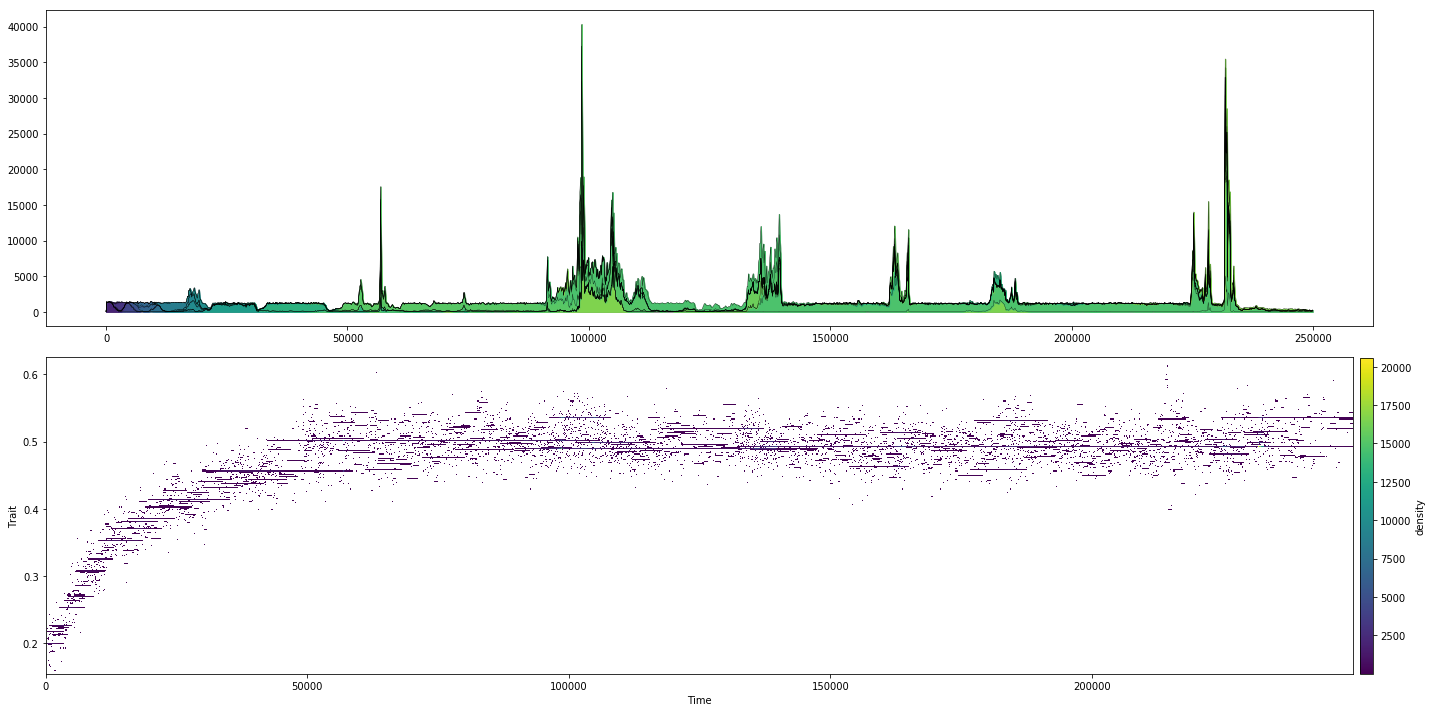

In [61]:
M = 10
traj, ptraj, tlist = discrete_bdm_process(T=250000, 
                                           steps=20000,
                                           skip=10,
                                           state=np.array([estimate_nstar(**p_neutral)]+[0]*M,dtype=int),
                                           phenotypes=np.array([0.2]*(M+1)),
                                           mutation_rate=0.1,
                                           mutation_effect=0.02,
                                           get_rates=partial(claessen2007, **p_neutral))
fig, (ax1,ax2) = plt.subplots(2, 1, figsize=(20,10))
plot_stack(traj,ptraj, tlist,ax=ax1)
plot_density(traj, ptraj, tlist,ax=ax2)
plt.tight_layout()
plt.savefig('trajectory.png',bbox_inches='tight')